# Synthetic drifter trajectories exponentially autocorrelated velocities

We generate synthetic exponentially autocorrelated velocity timeseries.
Displacement and acceleration timeseries are derived.

We verify pure exponentially decorrelated timeseries are not differentiable and lead to white noise acceleration.
A modification leading to differentiable solutions is used and consists in (multi-layer) embeded Ornstein–Uhlenbeck (OU) processes [Sawford 1991, Viggiano et al. 2020].
All processes are assumed Gaussian and could be extended to more general distributions [Viggiano et al. 2020].

References:

- B. Viggiano, J. Friedrich, R. Volk, M. Bourgoin, R. B. Cal, and L. Chevillard. Modelling lagrangian velocity and acceleration in turbulent flows as infinitely differentiable stochastic processes. Journal of Fluid Mechanics, 900, 2020.
- B. Sawford. Reynolds number effects in lagrangian stochastic models of turbulent dispersion. Physics of Fluids A: Fluid Dynamics, 3(6):1577–1586, 1991.


In [1]:
import os
import xarray as xr
import numpy as np
import viggiano_2020 as vig

import matplotlib.pyplot as plt
from cycler import cycler

from sstats import signals as sg
from sstats import sigp as sigp
from sstats import tseries as ts
from sstats import get_cmap_colors

from GDP_lib import root_dir

---

## exponentially autocorrelated low-frequency velocity signal


In [2]:
u_low = sg.low_frequency_signal()

# note we also could consider / add a high frequency component
# u_high = sg.high_frequency_signal()

- U = signal amplitude (standard deviation)
- $T$ = signal decorrelation time scale (exponential autocorrelation)

In [3]:
T, U = u_low.p["T"], u_low.p["U"]
# sigma = u_high.p['sigma']
omega, tau = u_low.omega, u_low.tau

# print analytical spectrum
u_low.spectrum

2*T*U**2/(T**2*omega**2 + 1)

Such spectrum leads to a flat acceleration spectrum at high frequencies which cannot be integrated and suggests acceleration is white noise. 
$\omega= 2\pi f$

## Generate

In [3]:
# decorrelation timescales
T = [5,10,20,40]
t = (1000, 1 / 24) # timeline: 1000 days with hourly sampling
N = 40 # number of random draws
u_std = 2

In [4]:
# generate velocity first
da = u_low.generate_tseries(
    params=dict(T=T),
    draws=N,
    time=t,
    seed=0,
)*u_std
# derive position and acceleration
ds = da.rename("u").assign_attrs(units="m/s").to_dataset().persist()
ds["time"] = ds["time"].assign_attrs(units="days")
ds["x"] = ds["u"].cumulative_integrate("time").assign_attrs(units="m") *86400 # rescale in m
ds["a"] = ds["u"].differentiate("time").assign_attrs(units="m/s^2") /86400  # rescale in m/s
ds = ds.persist()
print(1)
# compute autocorrelations
xx = sigp.correlate(ds.x, ds.x).rename("xx").persist().assign_attrs(long_name=r'$C_x(\tau)$', units="")
uu = sigp.correlate(ds.u, ds.u).rename("uu").persist().assign_attrs(long_name=r'$C_u(\tau)$', units="")
aa = sigp.correlate(ds.a, ds.a).rename("aa").persist().assign_attrs(long_name=r'$C_a(\tau)$', units="")
dsc = xr.merge([xx, uu, aa])
print(2)
# compute spectra
Ex, omega = sigp.spectrum_welch(ds.x, T=100)
Eu, omega = sigp.spectrum_welch(ds.u, T=100)
Ea, omega = sigp.spectrum_welch(ds.a, T=100)
dsE = xr.merge([Ex.assign_attrs(units=r"$m^2/cpd$"), Eu.assign_attrs(units=r"$m^2/s^2/cpd$"), Ea.assign_attrs(units=r"$m^2/s^4/cpd$")])
dsE = dsE.rename({i : 'E'+i for i in list(dsE.keys())})
print(3)
ds_exp = xr.merge([ds, dsc, dsE])

ds_exp.T.attrs = {'long_name' : 'Correlation time T', 'units':'days'}
ds_exp.lags.attrs = {'long_name':r'$\tau$', 'units':'days'}
ds_exp.freq_time.attrs = { 'units':'cpd'}

ds_exp.attrs = {'description':'synthetic trajectories simulated via the embedded OU process of Viggiano et al. 2020 (equations (2.14-2.18))', 'n_layers':1, "sigma_u":u_std}

1
2
3


In [8]:
ds = ds_exp

### Store

In [5]:
ds_exp0 = ds_exp.chunk({'T':4,'time' : 5000, 'draw':-1, 'lags':5000})
#ds_exp0['draw'] = xr.DataArray(np.arange(80,100), dims=['draw'])

In [6]:
#root_dir ='/Users/mdemol/code/PhD/GDP/synthetics_trajectories'
ds_exp0 = ds_exp.chunk({'T':4,'time' : 5000, 'draw':-1, 'lags':5000})
path = os.path.join(root_dir, "synthetic_traj_exp.zarr")

ds_exp0.to_zarr(path, mode="w")
#ds_exp0.to_zarr(path, mode="a", append_dim='draw')

## Or load

In [2]:
path = os.path.join(root_dir, "synthetic_traj_exp.zarr")
ds = xr.open_zarr(path, decode_timedelta=False)

________________
## Analysis

In [3]:
### Theoritical PSD or correlation for exponentially correlated process
def PSDu_exp(sigma, T, omega):
    return 2*T*sigma**2/(1+T**2*omega**2)
def PSDa_exp(sigma, T, omega):
    return 2*T*sigma**2/(1+T**2*omega**2)*(omega/86400)**2
def correlation_exp(tau, T, sigma):
    return sigma**2*np.exp(-tau/T)

In [4]:
ds['PSDu'] = PSDu_exp(ds.u.std('time').mean('draw'),ds.T,ds.freq_time*2*np.pi)
ds['PSDa'] = PSDa_exp(ds.u.std('time').mean('draw'),ds.T,ds.freq_time*2*np.pi)
ds['coru'] = correlation_exp(ds.lags, ds.T, ds.u.std('time').mean())
ds

<xarray.Dataset>
Dimensions:    (T: 4, draw: 40, freq_time: 2400, time: 24000, lags: 24000)
Coordinates:
  * T          (T) int64 5 10 20 40
  * draw       (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 31 32 33 34 35 36 37 38 39
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 ... 11.97 11.98 11.99
  * lags       (lags) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * time       (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
Data variables:
    Ea         (T, draw, freq_time) float64 dask.array<chunksize=(4, 40, 2400), meta=np.ndarray>
    Eu         (T, draw, freq_time) float64 dask.array<chunksize=(4, 40, 2400), meta=np.ndarray>
    Ex         (T, draw, freq_time) float64 dask.array<chunksize=(4, 40, 2400), meta=np.ndarray>
    a          (T, time, draw) float64 dask.array<chunksize=(4, 5000, 40), meta=np.ndarray>
    aa         (T, draw, lags) float64 dask.array<chunksize=(4, 40, 5000), meta=np.ndarray>
    u          (T, time, draw) float64 dask.array<chunksize=(4, 5000, 40), meta=np.ndarray>
    uu         (T, draw, lags) float64 dask.array<chunksize=(4, 40, 5000), meta=np.ndarray>
    x          (T, time, draw) float64 dask.array<chunksize=(4, 5000, 40), meta=np.ndarray>
    xx         (T, draw, lags) float64 dask.array<chunksize=(4, 40, 5000), meta=np.ndarray>
    PSDu       (T, freq_time) float64 dask.array<chunksize=(4, 2400), meta=np.ndarray>
    PSDa       (T, freq_time) float64 dask.array<chunksize=(4, 2400), meta=np.ndarray>
    coru       (lags, T) float64 dask.array<chunksize=(24000, 4), meta=np.ndarray>
Attributes:
    description:  synthetic trajectories simulated via the embedded OU proces...
    n_layers:     1
    sigma_u:      2

In [7]:
ds['PSDu'] = vig.PSDu_exp_ds(ds)
ds['PSDa'] = vig.PSDa_exp_ds(ds)
ds['coru'] = correlation_exp(ds.lags, ds.T, ds.u.std('time').mean())
ds

<xarray.Dataset>
Dimensions:    (T: 4, draw: 40, freq_time: 2400, time: 24000, lags: 24000)
Coordinates:
  * T          (T) int64 5 10 20 40
  * draw       (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 31 32 33 34 35 36 37 38 39
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 ... 11.97 11.98 11.99
  * lags       (lags) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * time       (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
Data variables:
    Ea         (T, draw, freq_time) float64 dask.array<chunksize=(4, 40, 2400), meta=np.ndarray>
    Eu         (T, draw, freq_time) float64 dask.array<chunksize=(4, 40, 2400), meta=np.ndarray>
    Ex         (T, draw, freq_time) float64 dask.array<chunksize=(4, 40, 2400), meta=np.ndarray>
    a          (T, time, draw) float64 dask.array<chunksize=(4, 5000, 40), meta=np.ndarray>
    aa         (T, draw, lags) float64 dask.array<chunksize=(4, 40, 5000), meta=np.ndarray>
    u          (T, time, draw) float64 dask.array<chunksize=(4, 5000, 40), meta=np.ndarray>
    uu         (T, draw, lags) float64 dask.array<chunksize=(4, 40, 5000), meta=np.ndarray>
    x          (T, time, draw) float64 dask.array<chunksize=(4, 5000, 40), meta=np.ndarray>
    xx         (T, draw, lags) float64 dask.array<chunksize=(4, 40, 5000), meta=np.ndarray>
    PSDu       (T, freq_time) float64 0.0002814 0.0002819 ... 3.53e-05 3.524e-05
    PSDa       (T, freq_time) float64 2.143e-10 2.143e-10 ... 2.679e-11
    coru       (lags, T) float64 dask.array<chunksize=(24000, 4), meta=np.ndarray>
Attributes:
    description:  synthetic trajectories simulated via the embedded OU proces...
    n_layers:     1
    sigma_u:      2

### PLOT

In [5]:
colors = get_cmap_colors(ds.T.size, cmap="plasma")
plt.rc('axes', prop_cycle=cycler(color=colors))

def plot_timeseries(ds, tmax=100):

    fig, axes = plt.subplots(3,1, figsize=(5,10), sharex=True)

    ax = axes[0]
    ds["x"].where(ds.time < tmax).plot.line(x="time", ax=ax);
    ax.grid()
    ax.set_title("")
    ax.set_xlabel("")


    ax = axes[1]
    ds["u"].where(ds.time < tmax).plot.line(x="time", ax=ax);
    ax.grid()
    ax.set_title("")
    ax.set_xlabel("")

    ax = axes[2]
    ds["a"].where(ds.time < tmax).plot.line(x="time", ax=ax);
    ax.grid()
    ax.set_title("")
    ax.set_xlabel("")
    
    return fig, axes

def plot_autocorrelations(ds, tau_max=100):

    fig, axes = plt.subplots(3,1, figsize=(5,10), sharex=True)

    ax = axes[0]
    ds["xx"].where(ds.lags < tau_max).plot.line(x="lags", ax=ax);
    ax.grid()
    ax.set_title("")
    ax.set_xlabel("")


    ax = axes[1]
    ds.coru.where(ds.lags < tau_max).plot.line(x="lags",  color='k',ls='--',ax=ax,);
    ds["uu"].where(ds.lags < tau_max).plot.line(x="lags", ax=ax);   
    ax.grid()
    ax.set_title("")
    ax.set_xlabel("")

    ax = axes[2]
    ds["aa"].where(ds.lags < tau_max).plot.line(x="lags", ax=ax);
    ax.grid()
    ax.set_title("")
    ax.set_xlabel("")

    return fig, axes

def plot_psd(ds, suffixes_ls ={'':'solid'}, suffixes_leg={'':''}, title='') : 
    fig, axs = plt.subplots(1,2, figsize=(9,5), sharex=True)#, sharey=True)
    def plot(ds,c):
        ax=axs[0]
        i=True
        for suf in suffixes_ls :  
            _E = ds['Eu'+suf].mean("draw")
            _Enorm = ds['Eu'].mean("draw").sel(freq_time=0)
            if i :
                _E.plot(x="freq_time", ax=ax, color=c, ls =suffixes_ls[suf], label=f"T={float(_T):.0f}d")
                i=False
            else : 
                _E.plot(x="freq_time", ax=ax, color=c, ls = suffixes_ls[suf])
        ds.PSDu.plot(color='k', ls=':', ax=ax)
        #ax.set_xlim(0,0.5)

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("f[cpd]")
        ax.set_ylabel("Velocity normalized power density spectra Eu")
        ax.grid()
        ax.set_title('(a)')
                
    
        ax=axs[1]
        for suf in suffixes_ls :  
            _E = ds['Ea'+suf].mean("draw")
            _Enorm = ds['Ea'].mean("draw").sel(freq_time=0)
            _E.plot(x="freq_time", ax=ax, color=c, ls = suffixes_ls[suf])
        ds.PSDa.plot(color='k',ls=':',ax=ax)
            
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("f[cpd]")
        ax.set_ylabel("Acceleration normalized power density spectra Ea")
        ax.set_title('(b)')

    if ds.T.size==1 : 
        _T=0
        plot(ds,colors[0],)
    else :
        for _T, c in zip(ds.T, colors):
            dsT = ds.sel(T=_T)
            plot(dsT,c)

    # Vertical limitation
    for ax in axs :
        if ds.T.size== 1: 
            Tl=np.array(ds.T)
        else:Tl=ds.T
        for i in range(Tl.size) : 
            if i==0 : ax.axvline(x = 1/Tl[i], color=colors[i], ls='--', label='1/T')
            else : ax.axvline(x = 1/ds.T[i], color=colors[i], ls='--')
        #ax.axvline(1/ds.attrs['tau_eta_days'], color = 'k',ls ='--', label=r'$1/\tau_{\eta}$')
   
    axs[0].legend()
    axs[0].grid()
    axs[1].grid()
    fig.tight_layout(rect=[0,0,1,0.95])#left, bottom, right, top (default is 0,0,1,1)
    fig.suptitle(title)
    
    return fig, axs

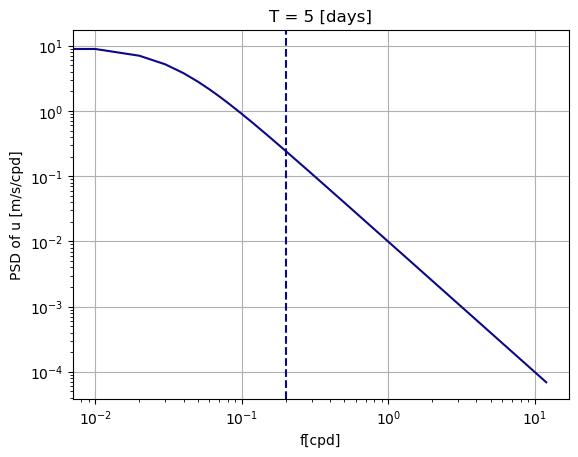

In [7]:
ds.PSDu.sel(T=5).plot(color = colors[0])
plt.axvline(1/5, ls='--', color = colors[0])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f[cpd]')
plt.ylabel('PSD of u [m/s/cpd]')
plt.grid()

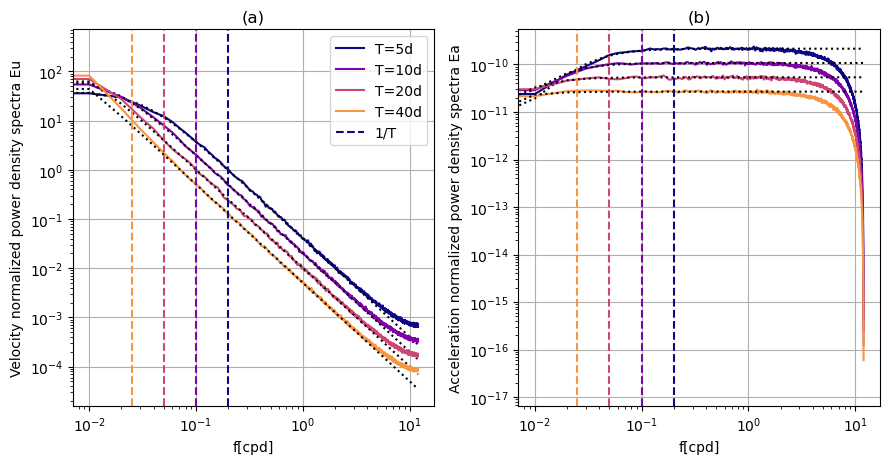

In [8]:
plot_psd(ds);

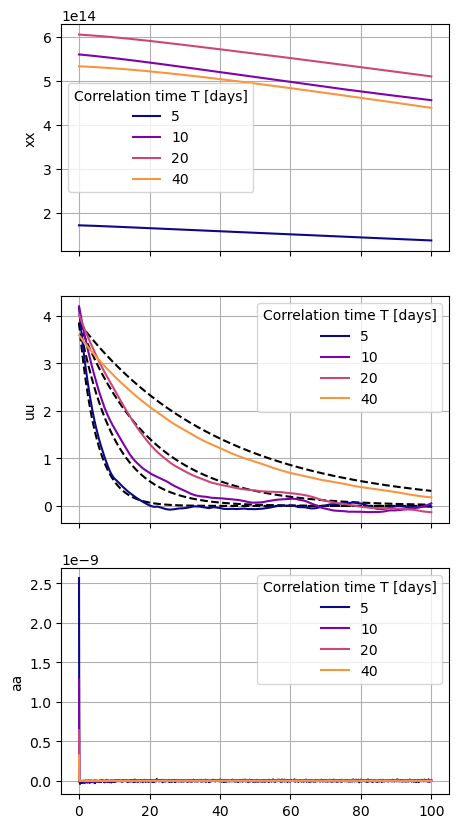

In [17]:
plot_autocorrelations(ds.mean('draw'), tau_max=100);

## Verify Parseval

In [12]:
ds.Eu.integrate("freq_time").compute()

<xarray.DataArray 'Eu' (T: 4, draw: 40)>
array([[0.85360207, 0.92999472, 1.01206013, 0.90944767, 1.12538786,
        0.92719452, 0.95970627, 0.76877344, 0.94162122, 1.02175077,
        1.14097551, 0.9326117 , 1.07348092, 1.05125756, 1.11614574,
        0.92346527, 1.01958959, 0.97808981, 1.02120397, 1.03134282,
        0.92377722, 1.12394057, 0.84188856, 1.15759772, 1.00250801,
        1.08357908, 1.19182518, 1.15643163, 1.0131047 , 1.04598938,
        1.01012042, 0.99287345, 1.00000468, 1.03418895, 0.98311314,
        0.98344282, 1.01775528, 0.97524968, 0.87890071, 0.97175959],
       [1.01728027, 1.15169942, 0.79792004, 1.06126874, 0.78896336,
        0.9371619 , 1.12051821, 1.06515227, 0.90542938, 0.92005644,
        0.88420512, 1.20479491, 0.85037546, 0.89158678, 0.96779026,
        0.92605818, 0.85880308, 0.93045631, 0.91659198, 0.87641422,
        0.94649858, 0.83207755, 0.92945909, 1.18587339, 1.00515122,
        1.01462188, 1.30220196, 1.07799252, 0.85517815, 0.82985808,
        0.90133226, 0.86447193, 1.14177111, 0.97595308, 1.00468017,
        1.00692413, 0.81215408, 0.82136562, 0.80985833, 1.06770848],
       [0.77323527, 0.93964035, 1.16745764, 1.00564573, 1.1000356 ,
        1.35409532, 1.00754271, 0.99852687, 0.61553245, 0.84607841,
        0.81458177, 1.41609825, 1.02544582, 1.50343875, 0.85982987,
        0.91064933, 0.83071282, 0.80971905, 0.90345196, 0.61326843,
        0.88856538, 0.85639935, 0.82104518, 1.04256397, 0.86360091,
        0.89728444, 0.961052  , 1.01134693, 1.15402361, 0.6947048 ,
        0.94707015, 1.02160352, 0.81242428, 1.07775223, 0.74141034,
        1.16709428, 1.18120461, 0.91445589, 0.96804664, 1.21911186],
       [1.41629994, 0.75104096, 1.02516934, 1.20166455, 1.13542457,
        1.04079607, 1.08010976, 0.84593012, 0.64802561, 0.83447701,
        1.07378706, 1.4815901 , 0.61048505, 1.26270994, 0.953935  ,
        0.98186961, 0.93743249, 0.73296956, 0.69455074, 1.4996787 ,
        1.05094397, 1.08308972, 0.95494522, 0.67464436, 1.22108635,
        1.59941717, 1.70560501, 1.11577031, 0.92773774, 1.32645388,
        0.86424271, 0.90338352, 1.7478176 , 0.78362762, 0.88297514,
        0.854885  , 0.85524843, 1.09303551, 0.73920597, 0.94353936]])
Coordinates:
  * T        (T) int64 5 10 20 40
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 30 31 32 33 34 35 36 37 38 39

In [13]:
ds.PSDu.integrate("freq_time").compute()

<xarray.DataArray 'PSDu' (T: 4)>
array([0.98073165, 0.93864004, 0.93182006, 1.08954041])
Coordinates:
  * T        (T) int64 5 10 20 40